<a href="https://colab.research.google.com/github/Nicordaro/2014-07-03_B/blob/master/kernel6491183f53.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Cloning files needed*

In [0]:
import os
# Clone github repository with data
# if os.path.isdir('./Project_MLDL'):
!rm -rf Project_MLDL
if not os.path.isdir('./CIFAR100_tError'):
  !git clone https://github.com/Nicordaro/Project_MLDL


Cloning into 'Project_MLDL'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 492 (delta 33), reused 0 (delta 0), pack-reused 429
Receiving objects: 100% (492/492), 1.30 MiB | 3.00 MiB/s, done.
Resolving deltas: 100% (271/271), done.


**Imports**

---

In [0]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import time
import gc
import seaborn as sns




from PIL import Image
from Project_MLDL.confusion_matrix import *
from Project_MLDL.CIFAR100_tError import CIFAR100_tError
from Project_MLDL.model_finetuning import ResNet18
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn
from torchvision import transforms
from torchvision.models import resnet18
from torchvision.models import resnet34
from tqdm import tqdm

# Garbage collector
gc.enable()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Arguments**

---





In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

# Init at 10 because first train is on 10 classes
NUM_CLASSES = 10

# Used for the pseudorandom shuffle of the split
SEED = 19

BATCH_SIZE = 128     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 2         # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 1e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 70     # Total number of training epochs (iterations over dataset)
MILESTONES = [48, 62]  # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.2          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 50

**Transformations definition**

---



In [0]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), # Randomly flip the image with probability of 0.5
                                      transforms.Pad(4), # Add padding
                                      transforms.RandomCrop(32),# Crops a random squares of the image
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) 
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                 
])
eval_transform = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                 
])
exemplar_transform = transforms.Compose([transforms.RandomHorizontalFlip(), # Randomly flip the image with probability of 0.5
                                      transforms.Pad(4), # Add padding
                                      transforms.RandomCrop(32),# Crops a random squares of the image
                                      transforms.ToTensor() # Turn PIL Image to torch.Tensor
])

*New label function*

In [0]:
DATA_DIR = './CIFAR100'

lbls = [i for i in range(0,100)]  #Array of classes integer-encoded (?)
random.seed(SEED)
random.shuffle(lbls)

def make_data_labels(lbls):     #After shuffle, take first 10 classes, and remove the first 10 from the list passed as argument
    new_labels=[]
    for el in lbls[:10]:
        new_labels.append(el)
    lbls = lbls[10:]

    return lbls, new_labels

In [0]:
from torch.utils.data import Dataset
"""
Take 2 datasets and combine them
"""
class joint_dataset(Dataset):
    
    def __init__(self,d1,d2):
        self.l1 = len(d1)
        self.l2 = len(d2)
        self.d1 = d1
        self.d2 = d2
    def __getitem__(self,index):
        if index>=self.l1:
            image,label = self.d2[index-self.l1]
            image = exemplar_transform(image) # Apply transformations to images
            return image,label
        else:
            image,label = self.d1[index]
            return image,label
    def __len__(self):
        return (self.l1 + self.l2)
        

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import copy
from torch.autograd import Variable

class iCaRL(nn.Module):
  def __init__(self):
    super(iCaRL, self).__init__()

    # CNN with 100 neurons in the last layer (Features Extractor + FC)
    self.net = ResNet18()
    self.net.linear = nn.Linear(512, 100)
    
    # Classification and Distillation losses
    self.cls_loss = nn.BCEWithLogitsLoss()
    self.dist_loss = nn.BCELoss()
    
    self.exemplar_sets=[] # List of exemplar sets, one for each class
    self.exemplars_means=[] # List of exemplar means, one for each exemplar set

  def classify(self, x):

    torch.no_grad()
    torch.cuda.empty_cache()
    
    feature_extractor = self.net.to(DEVICE)
    feature_extractor.train(False)

    size = x.size(0) # Take batch size

    means = torch.cat(self.exemplar_means,dim=0) # Tensor of means (num_classes,num_features)
    means = torch.stack([means]*size) # (batch_size,num_classes,num_features)
    means = means.transpose(1, 2) # (batch_size,num_features,num_classes)
    
    feature_x = feature_extractor.extract_features(x) # (batch_size, num_features)
    
    # Normalize features
    features_normalized = []
    for x in feature_x:
        x.data = x.data / x.data.norm()
        features_normalized.append(x)   
    feature_x = torch.stack(features_normalized,dim=0)

    feature_x = feature_x.unsqueeze(2) # (batch_size, feature_size, 1)
    feature_x = feature_x.expand_as(means) # (batch_size, feature_size, n_classes)

    # find the nearest prototype
    means = means.to(DEVICE)
    labels = torch.argmin((feature_x - means).pow(2).sum(1),dim=1)
    
    #clean memory
    del feature_x
    del means
    del x
    del feature_extractor
    torch.no_grad()
    torch.cuda.empty_cache()
    gc.collect()
    
    return labels

  def compute_means(self,X):
    torch.no_grad()  
    torch.cuda.empty_cache()

    # Given the exemplar sets, compute the means

    exemplar_means = []
    feature_extractor = self.net.to(DEVICE)
    feature_extractor.train(False)

    with torch.no_grad():
      # Don't take the last 10 classes
      for i,Py in enumerate(self.exemplar_sets):
        if i>=(len(self.exemplar_sets)-10):
          break
        features=[]
        for p in Py:
          p = p.to(DEVICE)
          feature = feature_extractor.extract_features(p)
          features.append(feature)
          #Clean Memory
          del p
          del feature
          torch.no_grad()
          torch.cuda.empty_cache()

        features = torch.stack(features) # (num_exemplars,num_features)
        mu_y = features.mean(0) 
        mu_y.data = mu_y.data / mu_y.data.norm() # Normalize
        mu_y = mu_y.to('cpu')
        exemplar_means.append(mu_y)
        del features
        del mu_y
        torch.no_grad()  
        torch.cuda.empty_cache()

    #Compute the mean for the last 10 classes exemplars + dataset
    with torch.no_grad():
      exemplar_sets = self.exemplar_sets[-10:]
      for Py,x in zip(exemplar_sets,X):
        features=[]
        for p in Py:
          p = p.to(DEVICE)
          feature = feature_extractor.extract_features(p)
          features.append(feature)
          #Clean Memory
          del p
          del feature
          torch.no_grad()
          torch.cuda.empty_cache()
        for element in x:
          image,label = element
          image = image.unsqueeze(dim=0).to(DEVICE)
          feature = feature_extractor.extract_features(image)
          features.append(feature)
          #Clean Memory
          del image
          del feature
          torch.no_grad()
          torch.cuda.empty_cache()

        features = torch.stack(features) # (num_exemplars,num_features)
        mu_y = features.mean(0) 
        mu_y.data = mu_y.data / mu_y.data.norm() # Normalize
        mu_y = mu_y.to('cpu')
        exemplar_means.append(mu_y)
        del features
        del mu_y
        torch.no_grad()  
        torch.cuda.empty_cache()

    self.exemplar_means = exemplar_means

    #Clean Memory
    del exemplar_means
    del feature_extractor
    torch.no_grad()
    torch.cuda.empty_cache()

  def reduce_exemplar_sets(self,m):
    for y, P_y in enumerate(self.exemplar_sets):
      m = int(m)
      self.exemplar_sets[y] = P_y[:m] # keep only the first m exemplars
  
  def construct_exemplar_set(self,X,m):
    
    # X dataset containing all elements of class y

    torch.no_grad()
    torch.cuda.empty_cache()
    gc.collect()

    feature_extractor = self.net.to(DEVICE)
    feature_extractor.train(False)
    loader = DataLoader(X,batch_size=BATCH_SIZE,shuffle=True,drop_last=False,num_workers = 4) # create dataloader

    features = []
    
    for images,labels in loader:
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)
      feature = feature_extractor.extract_features(images)
      features.append(feature)
      del images
      del labels
      del feature
        
    features_stacked = torch.cat(features) # (num_elements,num_features)
    mean = features_stacked.mean(0) #(num_features)
    mean = torch.stack([mean]*features_stacked.size()[0])  # (num_elements,num_features)
    torch.cuda.empty_cache()
    P = [] # exemplar set
    extracted_features = []

    summa = torch.zeros(1,features_stacked.size()[1]).to(DEVICE) #(1,num_features)
    
    for k in range(1,int(m+1)):
      s = torch.cat([summa]*features_stacked.size()[0]) #(num_elements,num_features)
      index = torch.argmin((mean-(1/k)*(features_stacked+s)).pow(2).sum(1),dim=0)
      features_stacked[index] = features_stacked[index]*100
      pk = X[index.item()][0].unsqueeze(dim=0) # take the image, leave the label
      P.append(pk)
      phipk =  feature_extractor.extract_features(pk.to(DEVICE))
      summa = summa + phipk # update sum of features
      del pk 
   
    #Clear Memory
    del summa
    del features
    del features_stacked
    del mean
    del s
    del feature_extractor
    del loader
    torch.cuda.empty_cache()
    self.exemplar_sets.append(P)
    

  def update_representation(self,X): 
    
    trans = transforms.ToPILImage()
    #Take exemplars
    exemplars_dataset = []
    for i in range(0,len(self.exemplar_sets)):
        for exemplar in self.exemplar_sets[i]:
            exemplar = trans(exemplar.squeeze()).convert("RGB")
            exemplars_dataset.append((exemplar,i)) #append the image in the list with label = index

    D = joint_dataset(X,exemplars_dataset) # Build the dataset 
   
    net = self.net

    #optimizer
    optimizer = optim.SGD(net.parameters(), lr=LR, weight_decay=WEIGHT_DECAY, momentum=MOMENTUM)

    # Scheduler
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=MILESTONES, gamma=GAMMA, last_epoch=-1)

    criterion = self.cls_loss
    criterion2 = self.dist_loss

    cudnn.benchmark # Calling this optimizes runtime

    current_step = 0
    net = net.to(DEVICE)
    
    # Create Dataloader 
    loader = DataLoader(D, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
    
    if len(self.exemplar_sets)>1:
        old = copy.deepcopy(net) #copy network before training
    
    #Training
    for epoch in range(NUM_EPOCHS):
      print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))

        # Iterate over the dataset
      for images, labels in loader:
          # Bring data over the device of choice
          images = images.to(DEVICE)
          labels = labels.to(DEVICE)
          net.train()
        
          optimizer.zero_grad() # Zero-ing the gradients

          # Forward pass to the network
          outputs = net(images)

          # One hot encoding labels for binary cross-entropy loss
          labels_onehot = nn.functional.one_hot(labels,100).type_as(outputs)

          # Compute Loss 
          if len(self.exemplar_sets)==0:
            loss = criterion(outputs, labels_onehot)
          else:
            labels_onehot = labels_onehot.type_as(outputs)[:,len(self.exemplar_sets):]
            out_old = Variable(torch.sigmoid(old(images))[:,:len(self.exemplar_sets)],requires_grad = False)
        
            target = torch.cat((out_old,labels_onehot),dim=1)
            loss = criterion(outputs,target)

          if current_step % LOG_FREQUENCY == 0:
              print('Step {}, Loss {}'.format(current_step, loss.item()))

          loss.backward()  # backward pass: computes gradients
          optimizer.step() # update weights based on accumulated gradients
          current_step += 1
        
      scheduler.step()
    
    # Save the trained network and update features extractor
    self.net = copy.deepcopy(net)
    del net
    torch.no_grad()
    torch.cuda.empty_cache()

Extracting ./CIFAR100/cifar-100-python.tar.gz to ./CIFAR100
processing batch 1
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Starting epoch 1/70, LR = [2]
Step 0, Loss 0.7457559108734131
Starting epoch 2/70, LR = [2]
Step 50, Loss 0.021652206778526306
Starting epoch 3/70, LR = [2]
Step 100, Loss 0.020253567025065422
Starting epoch 4/70, LR = [2]
Step 150, Loss 0.017576832324266434
Starting epoch 5/70, LR = [2]
Starting epoch 6/70, LR = [2]
Step 200, Loss 0.017677469179034233
Starting epoch 7/70, LR = [2]
Step 250, Loss 0.016770051792263985
Starting epoch 8/70, LR = [2]
Step 300, Loss 0.015838196501135826
Starting epoch 9

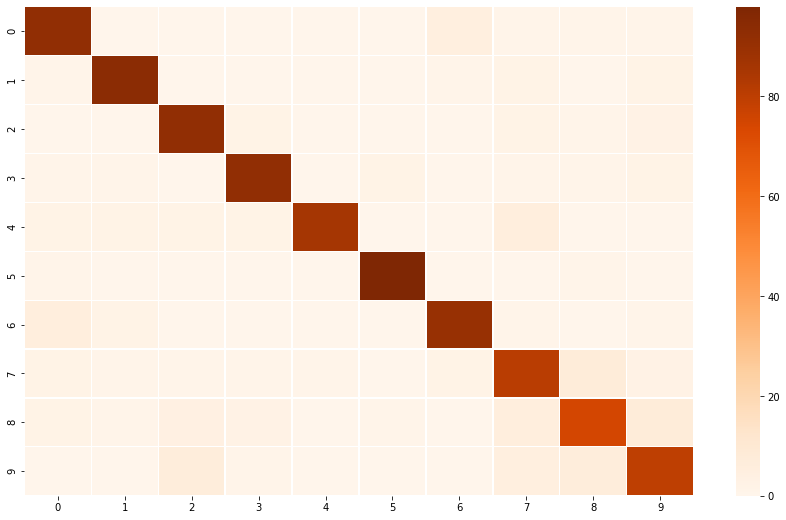

processing batch 2
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Starting epoch 1/70, LR = [2]
Step 0, Loss 0.14283601939678192
Starting epoch 2/70, LR = [2]
Step 50, Loss 0.029612554237246513
Starting epoch 3/70, LR = [2]
Step 100, Loss 0.02606203220784664
Starting epoch 4/70, LR = [2]
Step 150, Loss 0.023549441248178482
Starting epoch 5/70, LR = [2]
Step 200, Loss 0.021047847345471382
Starting epoch 6/70, LR = [2]
Step 250, Loss 0.022830672562122345
Starting epoch 7/70, LR = [2]
Step 300, Loss 0.02264854870736599
Starting epoch 8/70, LR = [2]
Step 350, Loss 0.01922471448779106
Starting epoch 9/70, LR = [2]
Step 400, Lo

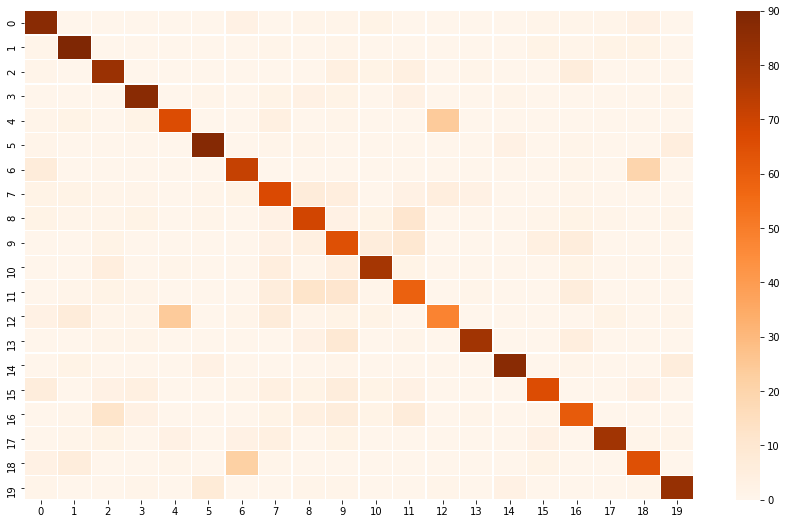

processing batch 3
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Starting epoch 1/70, LR = [2]
Step 0, Loss 0.09611863642930984
Starting epoch 2/70, LR = [2]
Step 50, Loss 0.031004898250102997
Starting epoch 3/70, LR = [2]
Step 100, Loss 0.027990788221359253
Starting epoch 4/70, LR = [2]
Step 150, Loss 0.028638485819101334
Starting epoch 5/70, LR = [2]
Step 200, Loss 0.02569844014942646
Starting epoch 6/70, LR = [2]
Step 250, Loss 0.026991086080670357
Starting epoch 7/70, LR = [2]
Step 300, Loss 0.023179447278380394
Starting epoch 8/70, LR = [2]
Step 350, Loss 0.02833612821996212
Starting epoch 9/70, LR = [2]
Step 400, L

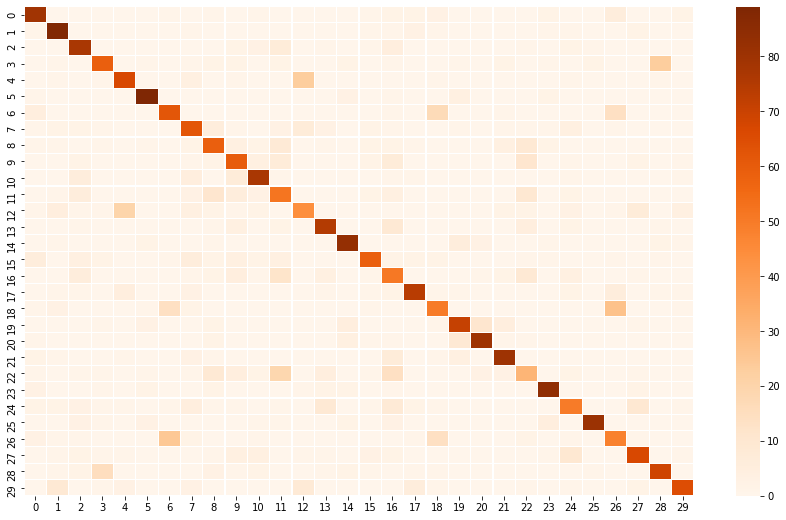

processing batch 4
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Starting epoch 1/70, LR = [2]
Step 0, Loss 0.08872232586145401
Step 50, Loss 0.038795195519924164
Starting epoch 2/70, LR = [2]
Step 100, Loss 0.03690018504858017
Starting epoch 3/70, LR = [2]
Step 150, Loss 0.03624192997813225
Starting epoch 4/70, LR = [2]
Step 200, Loss 0.02996950037777424
Starting epoch 5/70, LR = [2]
Step 250, Loss 0.03868298977613449
Starting epoch 6/70, LR = [2]
Step 300, Loss 0.031171340495347977
Starting epoch 7/70, LR = [2]
Step 350, Loss 0.031672921031713486
Starting epoch 8/70, LR = [2]
Step 400, Loss 0.03226466104388237
Starting

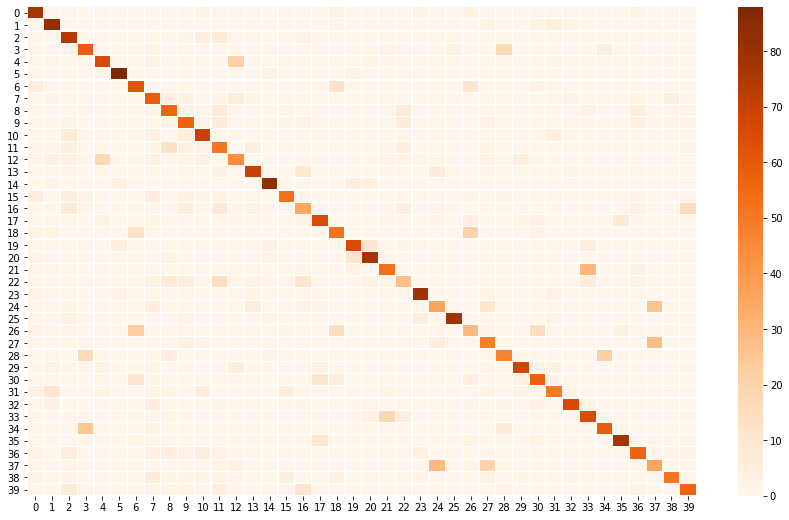

processing batch 5
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Starting epoch 1/70, LR = [2]
Step 0, Loss 0.09340474754571915
Step 50, Loss 0.051505912095308304
Starting epoch 2/70, LR = [2]
Step 100, Loss 0.049106664955616
Starting epoch 3/70, LR = [2]
Step 150, Loss 0.04768647998571396
Starting epoch 4/70, LR = [2]
Step 200, Loss 0.04444674775004387
Starting epoch 5/70, LR = [2]
Step 250, Loss 0.04412525147199631
Starting epoch 6/70, LR = [2]
Step 300, Loss 0.03393663465976715
Starting epoch 7/70, LR = [2]
Step 350, Loss 0.04642883315682411
Starting epoch 8/70, LR = [2]
Step 400, Loss 0.038254011422395706
Starting ep

KeyboardInterrupt: ignored

In [0]:
net = iCaRL()
K = 1000 # Memory Size
t = 0 # Number of classes
accuracies = [] # List of results 
test_dataset = CIFAR100_tError(DATA_DIR, train=False, transform=eval_transform, download=True)

for i in range(0,10): # batches of 10
  print(f"processing batch {i+1}")
  #Create Datasets
  train_datasets = []
  train_dataset_big = CIFAR100_tError(DATA_DIR, train=True, transform=train_transform, download=True)
  lbls, new_labels = make_data_labels(lbls) # take 10 new classes
  for label in new_labels:
    train_dataset = CIFAR100_tError(DATA_DIR, train=True, transform=eval_transform, download=True)
    train_dataset.increment([label],[t])
    test_dataset.increment([label],[t])
    train_dataset_big.increment([label],[t])
    train_datasets.append(train_dataset) # List of training examples in per class sets
    t += 1
  test_dataloader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=4)
  net.update_representation(train_dataset_big)
  m = K/t #numbers of exemplars per class
  matrix = new_confusion_matrix(lenx=t, leny=t)
  #net.reduce_exemplar_sets(m)
  for X in train_datasets:
    print("Construct Exemplar")
    net.construct_exemplar_set(X,m) #new exemplar sets
    torch.no_grad()
    torch.cuda.empty_cache()
    gc.collect()
  # Test on Test set
  running_corrects = 0
  print("Computing Means")
  net.compute_means(train_datasets)
  print("classifing")
  for images,labels in test_dataloader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
    preds = net.classify(images)
    update_confusion_matrix(matrix, preds, labels)
    running_corrects += torch.sum(preds == labels.data).data.item()
    accuracy = running_corrects / float(len(test_dataset))
    del images
    del labels
    del preds
    torch.no_grad()
    torch.cuda.empty_cache()
    gc.collect()
  accuracies.append(accuracy)
  print(f"Test Accuracy: {accuracy}")
  show_confusion_matrix(matrix)

**Define plot function**

---



In [0]:
def accuracy_plot(accuracies):
  ### FOR MEAN STD PLOT https://stackoverflow.com/questions/22481854/plot-mean-and-standard-deviation
  from scipy import interpolate

  tck,u     = interpolate.splprep( [[i*10 for i in range(1,len(accuracies)+1)],accuracies] ,s = 0 )
  xnew,ynew = interpolate.splev( np.linspace( 0, 1, 100 ), tck,der = 0)

  fig, ax = plt.subplots(figsize=(15,14), facecolor='white')

  plt.rc('font', size=20)
  plt.plot( [i*10 for i in range(1,len(accuracies)+1)],accuracies,'.' , xnew ,ynew, label = "accuracy", c='orange' )
  ax.set_ylabel("Accuracy")
  ax.set_xlabel("Classes")
  ax.minorticks_on()
  plt.title("Accuracies obtained with Icarl")
  plt.yticks(np.arange(0, 1.1, .1))
  plt.xticks(np.arange(0, 110, 10))
  plt.grid(axis='y',which='major', linestyle='-', linewidth='0.5', color='black') 
  plt.grid(axis='y',which='minor', linestyle=':', linewidth='0.5', color='grey')
  for in_i, in_j in zip([i*10 for i in range(1,len(accuracies)+1)], accuracies):  # Plot also the value of the point close to it
          ax.annotate(str(round(in_j, 3)), xy=(in_i, in_j))

  plt.savefig('test.png', format='png', dpi=300)
  plt.show()

*Print & Plot*

In [0]:
print(accuracies)

accuracy_plot(accuracies)
